## 波动率与隐含波动率


In [2]:
import pymongo
import pandas as pd
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [3]:
symbolList = ['btc_usdt.spot:binance', 'eth_usdt.spot:binance']
client = pymongo.MongoClient('172.16.20.81', 27017)

In [4]:
def readDb(collection, start, end):
    return pd.DataFrame(
        list(collection.find({"datetime": {'$gt': start, '$lt': end}}))
    )

In [57]:
startTime = datetime(2021,12,31)
sampleEndTime = datetime(2023,1,1)
endTime = datetime(2023,1,6, 1)
dbClient = client['Kline_1Min_Auto_Db_Plus']
columnsName = ['open', 'high', 'low', 'close', 'volume','datetime']

In [58]:
crytoDict = {
                'btc':readDb(dbClient[symbolList[0]], start=startTime , end=endTime)[columnsName],
                'eth':readDb(dbClient[symbolList[1]], start=startTime , end=endTime)[columnsName]
            }

In [59]:
def resampleDf(data, freq='H'):
    dataDf = df.set_index('datetime')
    dataHourDf = dataDf.resample(freq).agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
    dataResetDf = dataHourDf.reset_index()
    return dataResetDf

In [60]:
def addSymbol(dataDf, symbolName):
    dataDf['symbol'] = symbolName
    return dataDf

In [61]:
def setIndex(dataDf):
    dataIndex = dataDf.set_index(['datetime', 'symbol'])
    return dataIndex

In [62]:
multiCryptoDict = {}
for key, df in crytoDict.items():
    hourDf = resampleDf(df)
    hourSymbolDf = addSymbol(hourDf, key)
    hourIndexDf = setIndex(hourSymbolDf)
    multiCryptoDict[key] = hourIndexDf

In [63]:
multiDf = pd.concat(list(multiCryptoDict.values())).sort_index()

In [64]:
multiDf

open      high       low     close  \
datetime            symbol                                           
2021-12-31 00:00:00 btc     47193.46  47640.00  47092.13  47578.69   
                    eth      3711.39   3762.08   3705.39   3756.80   
2021-12-31 01:00:00 btc     47578.69  47770.00  47467.08  47663.51   
                    eth      3756.81   3758.85   3736.66   3741.59   
2021-12-31 02:00:00 btc     47663.50  47887.07  47474.58  47860.75   
...                              ...       ...       ...       ...   
2023-01-05 22:00:00 eth      1247.50   1250.50   1242.81   1248.21   
2023-01-05 23:00:00 btc     16830.28  16879.82  16823.10  16842.94   
                    eth      1248.21   1252.75   1247.74   1249.11   
2023-01-06 00:00:00 btc     16842.94  16865.21  16823.22  16838.28   
                    eth      1249.11   1250.25   1247.21   1248.64   

                                 volume  
datetime            symbol               
2021-12-31 00:00:00 btc      1492.84248  
                    eth     12285.87890  
2021-12-31 01:00:00 btc      1127.83834  
                    eth      7067.92760  
2021-12-31 02:00:00 btc      1145.17908  
...                                 ...  
2023-01-05 22:00:00 eth     27517.32290  
2023-01-05 23:00:00 btc     12107.26285  
                    eth     16591.01280  
2023-01-06 00:00:00 btc      8064.05317  
                    eth      7907.51690  

[17810 rows x 5 columns]

In [65]:
dailyPeriod = 24

In [66]:
close = multiDf.close.unstack()

In [67]:
pctChange = close.pct_change().rolling(24).std()*((1440/24)**0.5)

In [68]:
sampleVol = pctChange.loc[:sampleEndTime]

In [69]:
sampleVol.describe()

symbol,btc,eth
count,8761.000000,8761.000000
mean,0.045896,0.062070
std,0.026107,0.034167
min,0.003596,0.008416
25%,0.029159,0.040491
50%,0.041054,0.055072
75%,0.055126,0.074726
max,0.212716,0.269987


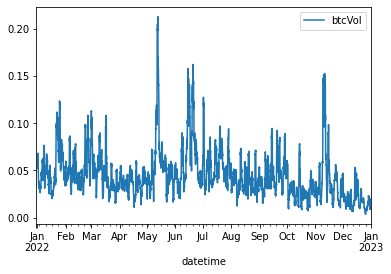

In [70]:
sampleVol['btc'].plot(label='btcVol')
plt.legend()

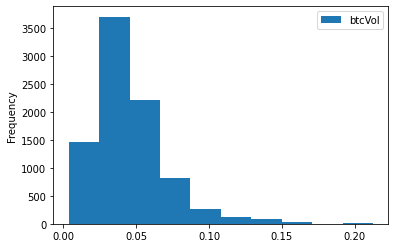

In [71]:
sampleVol['btc'].plot(kind='hist', label='btcVol')
plt.legend()

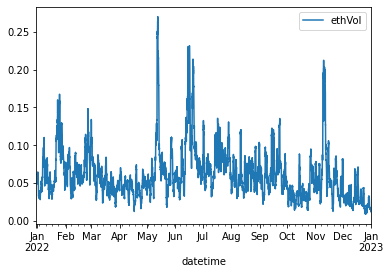

In [72]:
sampleVol['eth'].plot(label='ethVol')
plt.legend()

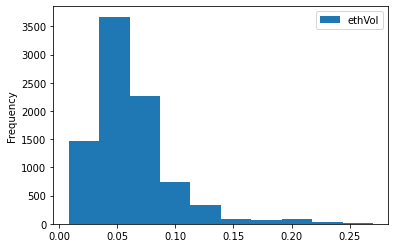

In [73]:
sampleVol['eth'].plot(kind='hist', label='ethVol')
plt.legend()

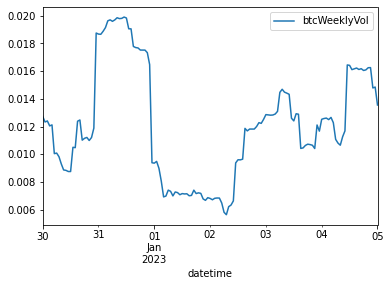

In [89]:
pctChange['btc'].loc[datetime(2022,12,30):datetime(2023,1,5,0)].plot(label='btcWeeklyVol')
plt.legend()

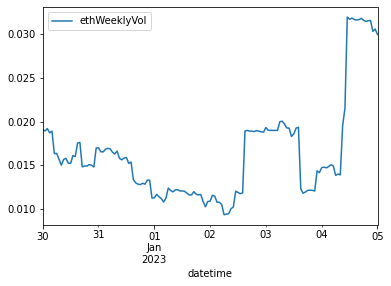

In [90]:
pctChange['eth'].loc[datetime(2022,12,30):datetime(2023,1,5,0)].plot(label='ethWeeklyVol')
plt.legend()

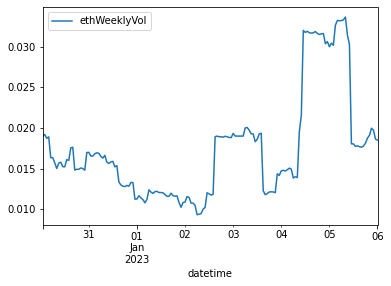

In [76]:
pctChange['eth'].iloc[-168:].plot(label='ethWeeklyVol')
plt.legend()

In [77]:
(pctChange['btc'].iloc[-1] - pctChange['btc'].iloc[-168])/pctChange['btc'].iloc[-168]

0.21285886485139804

In [78]:
(pctChange['eth'].iloc[-1] - pctChange['eth'].iloc[-168])/pctChange['eth'].iloc[-168]

-0.022519279787417256

In [79]:
pctChange['btc'].iloc[-168:].mean()

0.012592304416246989

In [80]:
from scipy.stats import percentileofscore
percentileofscore(pctChange['btc'], 0.0126)

4.4357102751263335

In [81]:
percentileofscore(pctChange['eth'], 0.0175)

2.459292532285233

In [82]:
btcIvDf = pd.read_csv('btcVol.csv')
ethIvDf = pd.read_csv('ethVol.csv')

In [83]:
btcIvDf.values

array([['2019-01-08 00:00:00;78.29'],
       ['2019-01-09 00:00:00;76.46'],
       ['2019-01-10 00:00:00;77.78'],
       ...,
       ['2023-01-02 00:00:00;50.14'],
       ['2023-01-03 00:00:00;52.08'],
       ['2023-01-04 00:00:00;46.13']], dtype=object)

In [31]:
btcIvDf['datetime'] = list(map(lambda dt: datetime.strptime(dt[0][:dt[0].find(';')], '%Y-%m-%d %H:%M:%S'), btcIvDf.values))

In [32]:
btcIvDf['iv'] = list(map(lambda dt: float(dt[0][dt[0].find(';')+1:]), btcIvDf.values))

In [33]:
btcIvData = btcIvDf[['datetime', 'iv']].set_index('datetime')

<AxesSubplot:xlabel='datetime'>

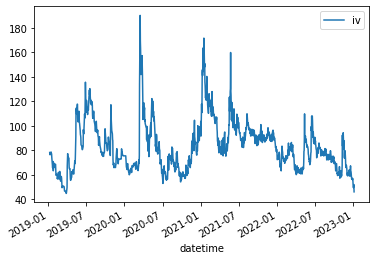

In [34]:
btcIvData.plot()